# Vignette

I've made a small tool while waiting for an airplane. It's a small wrapper around pandas that makes dataframe manipulation more functional. The goal was to give it a slightly more functional api for personal use. It sort of works and I would like to demonstrate the functionality in this document. It might not be a package that I'll offer a lot of support for, but it has some ideas that may be worth sharing. In this document I'll describe some functionality.

## Philosophy 

Data should be a noun and any manipulations on it should be described with verb. In R it is convenient to have those verbs be functions because the language allows you to write global operators that can chain functions togehter. In python it makes sense to have them wrapped with methods via an object instead.

The idea behind the tool is to have a more minimal api that accomodates 80-90% of the typical dataframe manipulations by attaching a few very useful composable verbs to a wrapped dataframer. This work is not meant to replace pandas nor is it meant as a python port of popular r-packages (though I'll gladly admit that a lot of ideas are bluntly copied from `tidyr` and `dplyr`). 

The goal of this work is to show a proof of concept to demonstrate extra composability and readability for python based data manipulation. Some performance sacrifices will ensue as a result. 

# Starting Point

To start to explain what the tool does, we need a dataset to start out with.

In [1]:
import numpy as np 
import pandas as pd 
import kadro as kd
%matplotlib inline

np.random.seed(42)
n = 20

df = pd.DataFrame({
    'a': np.random.randn(n),
    'b': np.random.randn(n),
    'c': ['foo' if x > 0.5 else 'bar' for x in np.random.rand(n)],
    'd': ['fizz' if x > 0.6 else 'bo' for x in np.random.rand(n)]
})
df = df.sort_values(['c', 'd'])

print(df)

           a         b    c     d
7   0.767435  0.375698  bar    bo
8  -0.469474 -0.600639  bar    bo
9   0.542560 -0.291694  bar    bo
13 -1.913280 -1.057711  bar    bo
14 -1.724918  0.822545  bar    bo
6   1.579213 -1.150994  bar  fizz
10 -0.463418 -0.601707  bar  fizz
11 -0.465730  1.852278  bar  fizz
16 -1.012831  0.208864  bar  fizz
18 -0.908024 -1.328186  bar  fizz
1  -0.138264 -0.225776  foo    bo
2   0.647689  0.067528  foo    bo
12  0.241962 -0.013497  foo    bo
15 -0.562288 -1.220844  foo    bo
19 -1.412304  0.196861  foo    bo
0   0.496714  1.465649  foo  fizz
3   1.523030 -1.424748  foo  fizz
4  -0.234153 -0.544383  foo  fizz
5  -0.234137  0.110923  foo  fizz
17  0.314247 -1.959670  foo  fizz


This is the data that we'll work with. We won't change the dataframe or it's api, rather we'll wrap it in an object that contains extra methods. 

In [2]:
kf = kd.Frame(df)
kf

Pandas derived TibbleFrame Object.

          a         b    c     d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

This new object contains the original pandas dataframe as a child, this means that you can always access the original data via `<obj_name>.df`. You will always be able to work with pure pandas if need be but a few methods are added to enchance readability and composability.

The added methods are: 

- mutate
- filter
- head/tail/slice
- select/rename/drop
- group_by/agg/ungroup
- sort
- sample_n
- pipe 
- gather 
- spread
- left_join, inner_join

If you're used to `dplyr` or Spark then you may recognize some of these functions. We'll demonstrate how they work one by one. 

## `tibble.mutate`

Mutate overwrites a column value or creates a new one. You specify the name of the column via the parameter name and you use a lambda function to describe the contents of the column. The input of the function will be the dataframe in the tibble object. This means that you can refer to columns but that you can also use numpy to describe changes. 

In [3]:
kf.mutate(e = lambda _: _['a'] + _['b']*2)

Pandas derived TibbleFrame Object.

          a         b    c     d         e
0  0.767435  0.375698  bar    bo  1.518831
1 -0.469474 -0.600639  bar    bo -1.670752
2  0.542560 -0.291694  bar    bo -0.040827
3 -1.913280 -1.057711  bar    bo -4.028702
4 -1.724918  0.822545  bar    bo -0.079828
5  1.579213 -1.150994  bar  fizz -0.722774
6 -0.463418 -0.601707  bar  fizz -1.666831
7 -0.465730  1.852278  bar  fizz  3.238827
8 -1.012831  0.208864  bar  fizz -0.595104
9 -0.908024 -1.328186  bar  fizz -3.564396
 only showing top 10 rows.

The column is added via a lambda function. This lambda function accepts the original dataframe. This allows you to refer to columns and allows you to apply any function you'd like. You can also create multiple columns in a single mutate statement.

In [4]:
(kf
  .mutate(e = lambda _: _['a'] + _['b']*2,
          f = lambda _: np.sqrt(_['e']),
          a = lambda _: _['a'] / 2))

/Users/code/anaconda3/envs/ds3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


Pandas derived TibbleFrame Object.

          a         b    c     d         e         f
0  0.383717  0.375698  bar    bo  1.518831  1.232409
1 -0.234737 -0.600639  bar    bo -1.670752       NaN
2  0.271280 -0.291694  bar    bo -0.040827       NaN
3 -0.956640 -1.057711  bar    bo -4.028702       NaN
4 -0.862459  0.822545  bar    bo -0.079828       NaN
5  0.789606 -1.150994  bar  fizz -0.722774       NaN
6 -0.231709 -0.601707  bar  fizz -1.666831       NaN
7 -0.232865  1.852278  bar  fizz  3.238827  1.799674
8 -0.506416  0.208864  bar  fizz -0.595104       NaN
9 -0.454012 -1.328186  bar  fizz -3.564396       NaN
 only showing top 10 rows.

You might appreciate that this method is somewhat lazy. You can use the 1st new column that you've created when creating your second one without the need to call `mutate` again. 

Notice that any numpy warnings that you may cause will still appear, but they won't cause the operation to fail. 

## `tibble.filter`

Filter creates a subset of the datastructure. Whenever the datastructure evaluates as true it will keep the row. 

In [5]:
(kf
  .filter(lambda _: _['a'] > 0, 
          lambda _: _['b'] > 0))

Pandas derived TibbleFrame Object.

          a         b    c     d
0  0.767435  0.375698  bar    bo
1  0.647689  0.067528  foo    bo
2  0.496714  1.465649  foo  fizz

Again you should notice a lazy structure. No need to call `.filter` multiple times as you can apply multiple filters in a single step. 

## `tibble.slice` 

In [6]:
kf.slice(2, 3, 10)

Pandas derived TibbleFrame Object.

          a         b    c   d
0  0.542560 -0.291694  bar  bo
1 -1.913280 -1.057711  bar  bo
2 -0.138264 -0.225776  foo  bo

In [7]:
kf.slice([2, 3, 10])

Pandas derived TibbleFrame Object.

          a         b    c   d
0  0.542560 -0.291694  bar  bo
1 -1.913280 -1.057711  bar  bo
2 -0.138264 -0.225776  foo  bo

## `tibble.head` and `tibble.tail` 

These methods are just like their pandas equivalents. The select the top rows or the bottom rows of the datastructure. 

In [8]:
kf.head(5)

Pandas derived TibbleFrame Object.

          a         b    c   d
0  0.767435  0.375698  bar  bo
1 -0.469474 -0.600639  bar  bo
2  0.542560 -0.291694  bar  bo
3 -1.913280 -1.057711  bar  bo
4 -1.724918  0.822545  bar  bo

In [9]:
kf.head(5).tail(3)

Pandas derived TibbleFrame Object.

          a         b    c   d
0  0.542560 -0.291694  bar  bo
1 -1.913280 -1.057711  bar  bo
2 -1.724918  0.822545  bar  bo

## `tibble.select` 

Select is merely a method to select a subset of columns. 

In [10]:
kf.select('b', 'c')

Pandas derived TibbleFrame Object.

          b    c
0  0.375698  bar
1 -0.600639  bar
2 -0.291694  bar
3 -1.057711  bar
4  0.822545  bar
5 -1.150994  bar
6 -0.601707  bar
7  1.852278  bar
8  0.208864  bar
9 -1.328186  bar
 only showing top 10 rows.

In [11]:
kf.select(['b', 'c'])

Pandas derived TibbleFrame Object.

          b    c
0  0.375698  bar
1 -0.600639  bar
2 -0.291694  bar
3 -1.057711  bar
4  0.822545  bar
5 -1.150994  bar
6 -0.601707  bar
7  1.852278  bar
8  0.208864  bar
9 -1.328186  bar
 only showing top 10 rows.

## `tibble.rename` 

The `.rename` method expects a dictionary of strings where the keys represent the new names and the values represent the old names. 

In [12]:
kf

Pandas derived TibbleFrame Object.

          a         b    c     d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

In [13]:
kf.rename({"aa":"a", "bb":"b"})

Pandas derived TibbleFrame Object.

          a         b    c     d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

## `tibble.set_names` 

The `.set_names` method expects a list of strings and will reset the column names of the dataframe. 

In [14]:
kf.set_names(["a", "b", "c", "omg_d"])

Pandas derived TibbleFrame Object.

          a         b    c omg_d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

## `tibble.drop` 

The `.drop` method allows you to pass column names of columns that can be dropped from the datastructure. 

In [15]:
kf.drop("a", "b")

Pandas derived TibbleFrame Object.

     c     d
0  bar    bo
1  bar    bo
2  bar    bo
3  bar    bo
4  bar    bo
5  bar  fizz
6  bar  fizz
7  bar  fizz
8  bar  fizz
9  bar  fizz
 only showing top 10 rows.

In [16]:
kf.drop(["a", "b"])

Pandas derived TibbleFrame Object.

     c     d
0  bar    bo
1  bar    bo
2  bar    bo
3  bar    bo
4  bar    bo
5  bar  fizz
6  bar  fizz
7  bar  fizz
8  bar  fizz
9  bar  fizz
 only showing top 10 rows.

## `tibble.group_by`

In [17]:
kf.group_by("c", "d")

Pandas derived TibbleFrame Object.
With groups ['c', 'd']

          a         b    c     d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

## `tibble.agg`

With the grouping attached you can easily aggregate with the `.agg` method. Notice that aggregating without a group will just regard the entire datastructure as a single group.

In [18]:
kf.agg(m_a = lambda _: np.mean(_['a']),
       v_b = lambda _: np.var(_['b']), 
       cov_ab = lambda _: np.cov(_['a'], _['b'])[1,1])

Pandas derived TibbleFrame Object.

     cov_ab       m_a       v_b
0  0.937099 -0.171299  0.890244

In [19]:
(kf
 .group_by("c", "d")
 .agg(m_a = lambda _: np.mean(_['a']),
      v_b = lambda _: np.var(_['b']), 
      cov_ab = lambda _: np.cov(_['a'], _['b'])[1,1]))

Pandas derived TibbleFrame Object.

     c     d       m_a       v_b    cov_ab
0  bar    bo -0.559536  0.453859  0.567323
1  bar  fizz -0.254158  1.343500  1.679374
2  foo    bo -0.244641  0.259796  0.324744
3  foo  fizz  0.373140  1.444080  1.805100

A few things to note. 

- in the `.agg` method you can pass any function that accepts a dataframe
- the `.agg` method can have multiple output columns that depend on different columns 
- you can even combine multiple columns in a lambda function 

## `tibble.sort`

In [20]:
kf.sort("a")

Pandas derived TibbleFrame Object.

          a         b    c     d
0 -1.913280 -1.057711  bar    bo
1 -1.724918  0.822545  bar    bo
2 -1.412304  0.196861  foo    bo
3 -1.012831  0.208864  bar  fizz
4 -0.908024 -1.328186  bar  fizz
5 -0.562288 -1.220844  foo    bo
6 -0.469474 -0.600639  bar    bo
7 -0.465730  1.852278  bar  fizz
8 -0.463418 -0.601707  bar  fizz
9 -0.234153 -0.544383  foo  fizz
 only showing top 10 rows.

Note that grouping a datastructure has an effect on how it is sorted.

In [21]:
kf.group_by("c", "d").sort("a")

Pandas derived TibbleFrame Object.
With groups ['c', 'd']

          a         b    c     d
0 -1.913280 -1.057711  bar    bo
1 -1.724918  0.822545  bar    bo
2 -0.469474 -0.600639  bar    bo
3  0.542560 -0.291694  bar    bo
4  0.767435  0.375698  bar    bo
5 -1.012831  0.208864  bar  fizz
6 -0.908024 -1.328186  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -0.463418 -0.601707  bar  fizz
9  1.579213 -1.150994  bar  fizz
 only showing top 10 rows.

## `tibble.ungroup`

In [22]:
kf.group_by("a")

Pandas derived TibbleFrame Object.
With groups ['a']

          a         b    c     d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

In [23]:
kf.group_by("a").ungroup()

Pandas derived TibbleFrame Object.

          a         b    c     d
0  0.767435  0.375698  bar    bo
1 -0.469474 -0.600639  bar    bo
2  0.542560 -0.291694  bar    bo
3 -1.913280 -1.057711  bar    bo
4 -1.724918  0.822545  bar    bo
5  1.579213 -1.150994  bar  fizz
6 -0.463418 -0.601707  bar  fizz
7 -0.465730  1.852278  bar  fizz
8 -1.012831  0.208864  bar  fizz
9 -0.908024 -1.328186  bar  fizz
 only showing top 10 rows.

## `tibble.sample_n`

In [24]:
kf.sample_n(10)

Pandas derived TibbleFrame Object.

          a         b    c     d
0 -0.234153 -0.544383  foo  fizz
1 -0.234137  0.110923  foo  fizz
2 -0.469474 -0.600639  bar    bo
3  1.579213 -1.150994  bar  fizz
4 -1.913280 -1.057711  bar    bo
5  0.496714  1.465649  foo  fizz
6 -0.465730  1.852278  bar  fizz
7  0.647689  0.067528  foo    bo
8  1.523030 -1.424748  foo  fizz
9 -1.012831  0.208864  bar  fizz

In [25]:
kf.sample_n(1000, replace=True).sort("a").head(5)

Pandas derived TibbleFrame Object.

         a         b    c   d
0 -1.91328 -1.057711  bar  bo
1 -1.91328 -1.057711  bar  bo
2 -1.91328 -1.057711  bar  bo
3 -1.91328 -1.057711  bar  bo
4 -1.91328 -1.057711  bar  bo

## `tibble.pipe` 

The `.pipe` method is a simple wrapper around the `pandas.DataFrame.pipe` method. It was the method I was using most from pandas and I did not want it's functionality removed. 

It is a very useful construct that allows you to add functions can can perform complex tasks on the datastructure. 

In [26]:
def heavy_func(frame, colname, multy):
    frame[colname] = frame[colname] * multy
    return frame
    
(kf
 .pipe(heavy_func, colname = "b", multy = 2)
 .pipe(heavy_func, colname = "a", multy = 10))

Pandas derived TibbleFrame Object.

           a         b    c     d
0   7.674347  0.751396  bar    bo
1  -4.694744 -1.201277  bar    bo
2   5.425600 -0.583387  bar    bo
3 -19.132802 -2.115422  bar    bo
4 -17.249178  1.645090  bar    bo
5  15.792128 -2.301987  bar  fizz
6  -4.634177 -1.203413  bar  fizz
7  -4.657298  3.704556  bar  fizz
8 -10.128311  0.417727  bar  fizz
9  -9.080241 -2.656372  bar  fizz
 only showing top 10 rows.

## `tibble.gather` 

In [27]:
kf.gather('key', 'value')

## `tibble.spread` 

## `tibble.left_join` 

In [28]:
df_age = pd.DataFrame({
    'name': ['vincent', 'tim', 'anna'],
    'age': [28, 30, 25]
})

df_length = pd.DataFrame({
    'name': ['vincent', 'tim'],
    'length': [188, 172]
})

kd_age = kd.Frame(df_age)
kd_length = kd.Frame(df_length)

In [29]:
kd_age.left_join(kd_length)

Pandas derived TibbleFrame Object.

   age     name  length
0   28  vincent   188.0
1   30      tim   172.0
2   25     anna     NaN

## `tibble.inner_join` 

In [30]:
kd_age.inner_join(kd_length)

Pandas derived TibbleFrame Object.

   age     name  length
0   28  vincent     188
1   30      tim     172

# Plotting

The `.plot` method exists in kadro and works just like pandas.

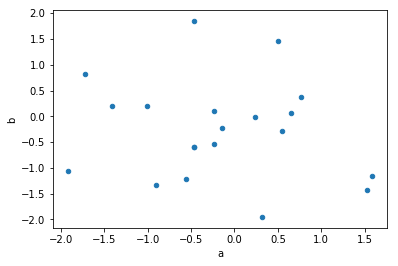

In [31]:
kf.plot('a', 'b', kind = 'scatter')

The nice thing about plotting is that this doesn't break your flow in kadro.

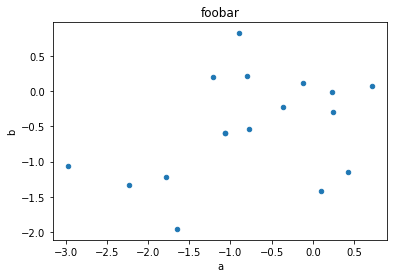

In [32]:
(kf
   .mutate(a = lambda _: _['a'] + _['b'])
   .filter(lambda _: _['a'] < 1)
   .plot('a', 'b', kind = 'scatter', title = 'foobar'))

# Caching 

Tibble assumes a bit of immutability. Whatever method you call, it will create a new tibble object to prevent any influence spreading to a parent. This also means that if you want to gain performance, you'll want to store intermediate results into a seperate object.